In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from bigml.api import BigML

In [2]:
api = BigML(project="project/5d9b851042129f40b70001b0") # AUTH dans docker/auth.env

In [3]:
df = pd.read_csv('csv/Train.csv', index_col=0)

In [4]:
def data_auc(n):
    
    # split de n% du train_set
    train_split = df.head(int(len(df)*(n/100)))

    ### Enregistrement csv 
    path = f"csv/learning_curves/train_split_{n}.csv"
    batch_path_ens = f"csv/learning_curves/predictions_ensemble_train{n}_with_val.csv"
    batch_path_deep = f"csv/learning_curves/predictions_deepnet_train{n}_with_val.csv"
    
    train_split.to_csv(path)

    # Creation d'une source
    source = api.create_source(path)
    api.ok(source)
    # Creation d'un dataset ( = source )
    dataset_train = api.create_dataset(source)
    api.ok(dataset_train)

    # Récuperation des 20% de Test 

    val_dataset = api.get_dataset('dataset/5dbf24715299631c8200fe3a')

    # Création d'un modele ensemble avec les n% 
    ensemble = api.create_ensemble(dataset_train , {"objective_field" : "SeriousDlqin2yrs"})
    print(f"Création model {n}% du train set - Ensemble")
    
    # Création d'un modele deepnet avec les n%
    
    deepnet = api.create_deepnet(dataset_train , {"objective_field" : "SeriousDlqin2yrs"})
    print(f"Création model {n}% du train set - Deepnet")
     
    # Récupération des batchs prédiction Ensemble - Deepnet 
    batch_prediction_ens = api.create_batch_prediction(ensemble, val_dataset,{"header": True, "all_fields": True, "probabilities": True})
    api.ok(batch_prediction_ens)
    api.download_batch_prediction(batch_prediction_ens,filename=batch_path_ens)
    
    batch_prediction_deep = api.create_batch_prediction(deepnet, val_dataset,{"header": True, "all_fields": True, "probabilities": True})
    api.ok(batch_prediction_deep)
    api.download_batch_prediction(batch_prediction_deep,filename=batch_path_deep)

    #### AUC 
    df_ens = pd.read_csv(batch_path_ens, index_col=0)
    df_deep = pd.read_csv(batch_path_deep, index_col=0)

    actual_ens = df_ens['SeriousDlqin2yrs']
    scores_ens = df_ens['1 probability']
    auc_ens = roc_auc_score(actual_ens, scores_ens)
    
    actual_deep = df_deep['SeriousDlqin2yrs']
    scores_deep = df_deep['1 probability']
    auc_deep = roc_auc_score(actual_deep, scores_deep)
      
    return auc_ens , auc_deep

In [5]:
n = 10
auc_list_ens = []
auc_list_deep = []
data_amount_list = []

while n <= 100:
    auc_ens , auc_deep = data_auc(n)
    auc_list_ens.append(auc_ens)
    auc_list_deep.append(auc_deep)
    data_amount_list.append(n)
    n += 10

Création model 10% du train set - Ensemble
Création model 10% du train set - Deepnet
Création model 20% du train set - Ensemble
Création model 20% du train set - Deepnet
Création model 30% du train set - Ensemble
Création model 30% du train set - Deepnet
Création model 40% du train set - Ensemble
Création model 40% du train set - Deepnet
Création model 50% du train set - Ensemble
Création model 50% du train set - Deepnet
Création model 60% du train set - Ensemble
Création model 60% du train set - Deepnet
Création model 70% du train set - Ensemble
Création model 70% du train set - Deepnet
Création model 80% du train set - Ensemble
Création model 80% du train set - Deepnet
Création model 90% du train set - Ensemble
Création model 90% du train set - Deepnet
Création model 100% du train set - Ensemble
Création model 100% du train set - Deepnet


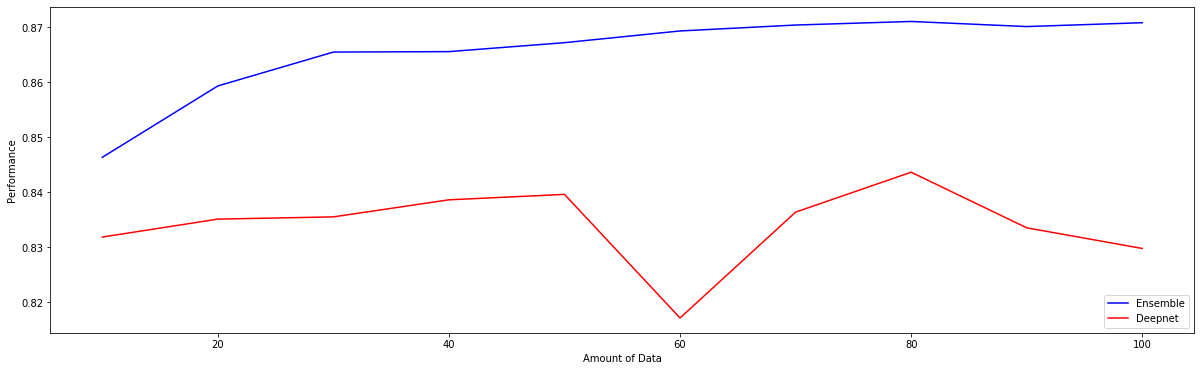

In [7]:
plt.rcParams['figure.figsize'] = [20.5 , 6]
plt.xlabel("Amount of Data")
plt.ylabel("Performance")
plt.plot(data_amount_list,auc_list_ens, color="blue", label='Ensemble')
plt.plot(data_amount_list,auc_list_deep, color="red", label='Deepnet')
plt.legend(loc="lower right")
plt.show()